# STEP 0

## 0.1. Imports


In [1]:
import pandas                   as pd
import seaborn                  as sns
import sweetviz                 as sv
import matplotlib.pyplot        as plt
import seaborn                  as sns
from sklearn.svm                import SVC 
from sklearn                    import metrics
from sklearn.pipeline           import Pipeline
from sklearn.model_selection    import GridSearchCV
# from sklearn.impute             import SimpleImputer
# from sklearn.model_selection    import cross_validate
from sklearn.model_selection    import train_test_split
from sklearn.compose            import ColumnTransformer
from sklearn.model_selection    import StratifiedKFold, KFold
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing      import LabelEncoder, OneHotEncoder, OrdinalEncoder

c:\Users\Usuário\repos\google_ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [2]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()


# # Faz o Cross Validation do modelo e retorna um dataframe com as métricas selecionadas
# def kfold_cross_validation(model, model_name, x, y, n_folds=3):
#     kf = StratifiedKFold(n_splits=n_folds)    
#     y = y.values
#     x = x.values
    
#     for train, test in kf.split(x, y):
#         data_train, target_train = x[train], y[train]
#         data_test, target_test   = x[test], y[test]
        
#         # Balanceando as classes
#         from imblearn.combine import SMOTETomek
#         smote_tomek = SMOTETomek(random_state=0)
#         data_train, target_train = smote_tomek.fit_resample(data_train, target_train)

#         # Aplicando scaler
#         mms = MinMaxScaler()
#         mms.fit(data_train)
#         data_train_norm = mms.transform(data_train)
#         data_test_norm = mms.transform(data_test)

#         model = model.fit(data_train_norm, target_train)
#         out = model.predict(data_test_norm)
        
#     data = [
#             [
#                 model_name,
#                 metrics.precision_score(target_test, out),
#                 metrics.recall_score(target_test, out),
#                 metrics.f1_score(target_test, out),
#                 metrics.roc_auc_score(target_test, out),
#             ]
#         ]
    
#     columns = ["Model", "Precision", "Recall", "F1", "AUC"]
#     metrics_table = pd.DataFrame(data, columns=columns)

#     # Confusion matrix
#     confusion = pd.crosstab(target_test, out, rownames=['Real'], colnames=['Predict'])
#     sns.heatmap(confusion, annot=True, fmt='g');

#     return metrics_table

# Calcula e retorna um dataframe com as métricas sem validação cruzada
def simple_metrics(model_name, test, predict):
    data = [
        [
            model_name,
            metrics.precision_score(test, predict),
            metrics.recall_score(test, predict),
            metrics.f1_score(test, predict),
            metrics.roc_auc_score(test, predict),
        ]
    ]
    columns = ["Model", "Precision", "Recall", "F1", "AUC"]
    metrics_table = pd.DataFrame(data, columns=columns)
    return metrics_table


def tuning_hyperparams(pre_processor, modelo, model_name, param, X, y):
    '''
        Método que utiliza o Pipeline para pré processar os dados e calcula quais são 
        os melhores hiperparâmetros baseado no modelo e no dicionário de hiperparâmetros 
        informados. Retorna um dicionário com os parâmetros testados e os melhores valores
        de cada um.

        pre_processor: objeto da classe ColumnTransformer escolhido para os dados
        modelo: instância do algoritimo a ser usado
        model_name: String com o apelido do modelo a ser usado
        param: Dict - dicionário com os hiperparams e os valores a serem testados
        X: dados de treino
        y: variável target dos dados de treino

        return dict
    '''
    # criando o modelo usando pipeline
    model = Pipeline(
        steps=[
            ("preprocessor", pre_processor),
            (model_name, modelo),
        ]
    )

    # Criando o dicionario de hiperparâmetros
    test_keys = [model_name + '__' + x for x in param.keys()] # colocar duplo underscore entre o nome do modelo e o nome do parâmetro  (lr__)
    test_values = list(param.values())
    parameters = { test_keys[i]: test_values[i] for i in range(len(test_keys)) }

    # Rodando 5-fold cross-validation com gridsearch
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True
    )

    grid.fit(X=X, y=y)

    # Imprime os melhores parâmetros
    param = grid.best_params_
    return param

## 0.3. Loading Data

In [3]:
test_raw = pd.read_csv('../data/test.csv')
train_raw = pd.read_csv('../data/train.csv')

# 1 - Data understanding


In [4]:
df = train_raw.copy()
df.head(3)

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado


## 1.1. Rename Columns

In [5]:
df.columns = ['id', 'continente', 'escolaridade',
       'tem_experiencia', 'requer_treinamento',
       'num_empregados', 'ano_fundacao', 'regiao',
       'salario_medio', 'periodicidade',
       'tempo_integral', 'status']

## 1.2. Data Dimensions

In [6]:
# Conferindo a volumetria
print(f"Quantidade de linhas:   {df.shape[0]}")
print(f"Quantidade de colunas:  {df.shape[1]}")
print(f"IDs únicos:             {df.id.nunique()}\n")

Quantidade de linhas:   17836
Quantidade de colunas:  12
IDs únicos:             17836



## 1.3. Data Types

In [7]:
df.dtypes

id                     object
continente             object
escolaridade           object
tem_experiencia        object
requer_treinamento     object
num_empregados          int64
ano_fundacao            int64
regiao                 object
salario_medio         float64
periodicidade          object
tempo_integral         object
status                 object
dtype: object

## 1.4. Change Data Types

In [8]:
'''
Alterando os tipos de int64 e float64 para int32 e float32 respectivamente com o 
intuito de melhorar a performance além de alterar as variáveis nominais para o tipo 
category que consome menos memória que o tipo object.
'''
df.id = df.id.astype('string')
df.continente = df.continente.astype('category')
df.escolaridade = df.escolaridade.astype('category')
df.tem_experiencia = df.tem_experiencia.astype('category')
df.requer_treinamento = df.requer_treinamento.astype('category')
df.num_empregados = df.num_empregados.astype('int32')
df.ano_fundacao = df.ano_fundacao.astype('int32')
df.regiao = df.regiao.astype('category')
df.salario_medio = df.salario_medio.astype('float32')
df.periodicidade = df.periodicidade.astype('category')
df.tempo_integral = df.tempo_integral.astype('category')
df.status = df.status.apply(lambda status: 0 if status == 'Negado' else 1)
df.status = df.status.astype('int32')

## 1.5. Check NA


In [9]:
df.isnull().mean()

id                   0.00
continente           0.00
escolaridade         0.00
tem_experiencia      0.00
requer_treinamento   0.00
num_empregados       0.00
ano_fundacao         0.00
regiao               0.00
salario_medio        0.00
periodicidade        0.00
tempo_integral       0.00
status               0.00
dtype: float64

## 1.6. Descriptive Statistical


In [10]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df.select_dtypes(include=['int32', 'float32'])
categorical_attributes = df.select_dtypes(exclude=['int32', 'float32'])

### 1.6.1 Numerical Features

In [11]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
num_empregados,17836.00,5726.50,23321.38,-26.00,1023.00,2117.00,3504.25,602069.00
ano_fundacao,17836.00,1979.49,42.10,1800.00,1976.00,1997.00,2005.00,2016.00
salario_medio,17836.00,74327.42,52795.86,2.14,33892.91,70106.92,107564.71,319210.28
status,17836.00,0.67,0.47,0.00,0.00,1.00,1.00,1.00


### 1.6.2 Categorical Features

In [12]:
display( pd.DataFrame( categorical_attributes.apply(lambda x: x.unique().shape[0]), columns=[ 'Valores únicos'], ).sort_values('Valores únicos'))

,Valores únicos
tem_experiencia,2
requer_treinamento,2
tempo_integral,2
escolaridade,4
periodicidade,4
regiao,5
continente,6
id,17836


### 1.7 Target Feature

In [13]:
df.status.value_counts()

1    11937
0     5899
Name: status, dtype: int64

# 2 - Exploratory data analisys

In [14]:
my_report = sv.analyze(df, target_feat ='status')
my_report.show_html()

c:\Users\Usuário\repos\google_ml\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\Usuário\repos\google_ml\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: status (TARGET)                     |▊         | [  8%]   00:00 -> (00:00 left)c:\Users\Usuário\repos\google_ml\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: id                                  |█▌        | [ 15%]   00:00 -> (00:01 left)c:\Users\Usuário\repos\google_ml\lib\site-packa

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 2.1. Análise Univariada

[Text(0.5, 1.0, 'Salário médio da profissão')]

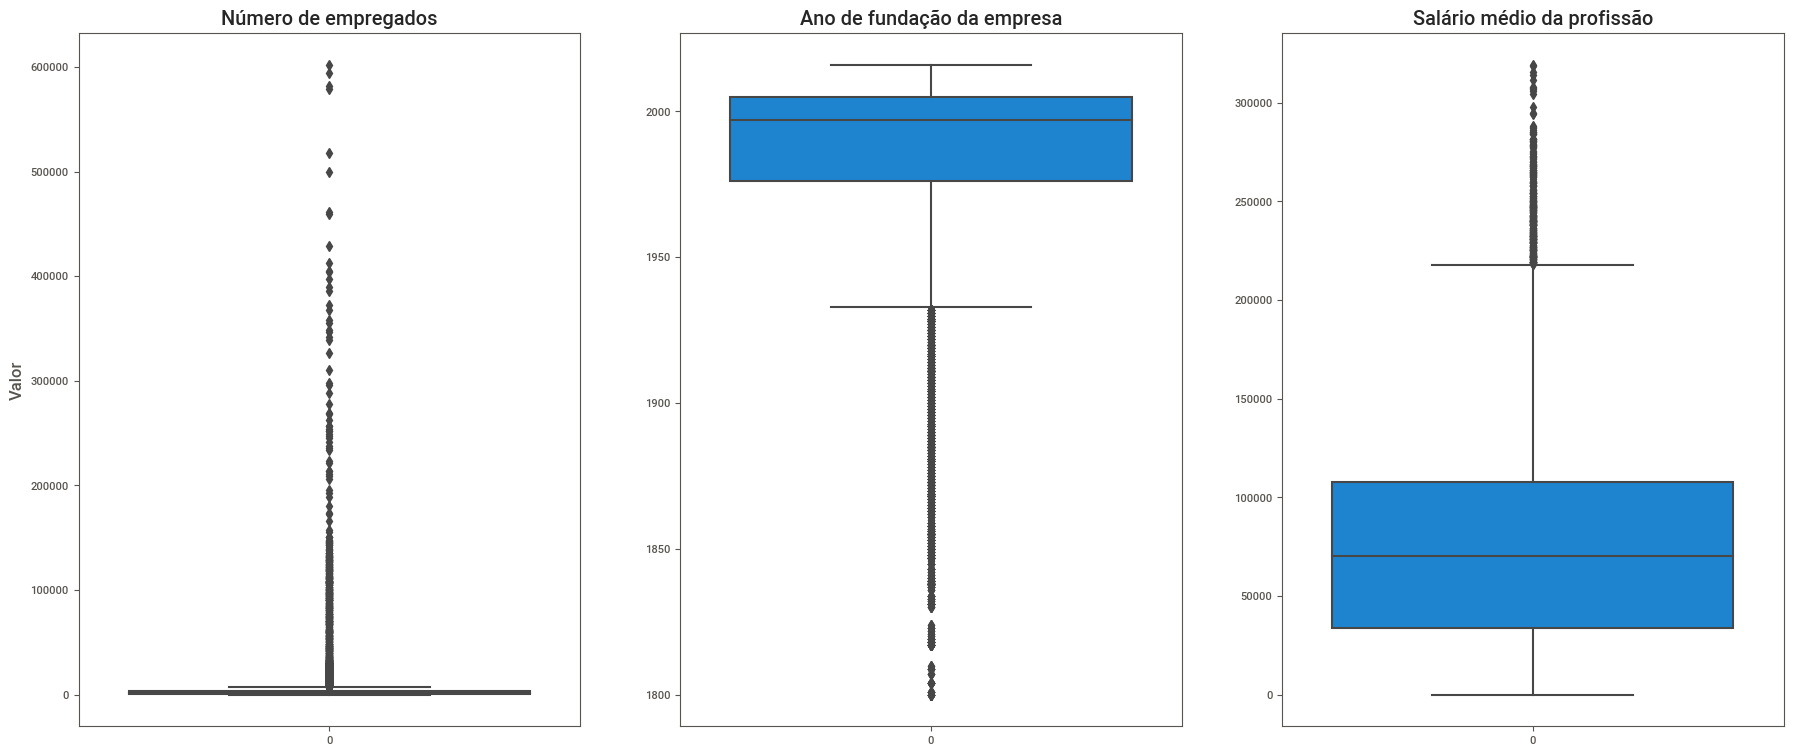

In [15]:
plt.subplot(1,3,1)
sns.boxplot(numerical_attributes['num_empregados']).set(title='Número de empregados', ylabel="Valor")

plt.subplot(1,3,2)
sns.boxplot(numerical_attributes['ano_fundacao']).set(title='Ano de fundação da empresa',)

plt.subplot(1,3,3)
sns.boxplot(numerical_attributes['salario_medio']).set(title='Salário médio da profissão')

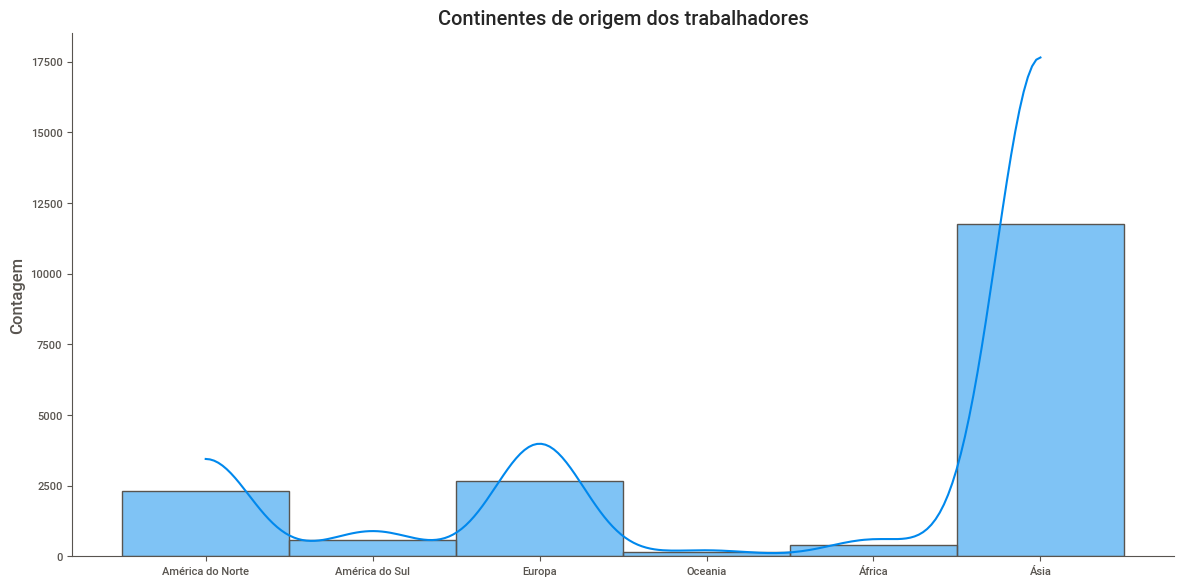

In [16]:
sns.displot(data=df, x="continente", kde=True, height=6, aspect=2).set(title='Continentes de origem dos trabalhadores', xlabel=None, ylabel='Contagem');

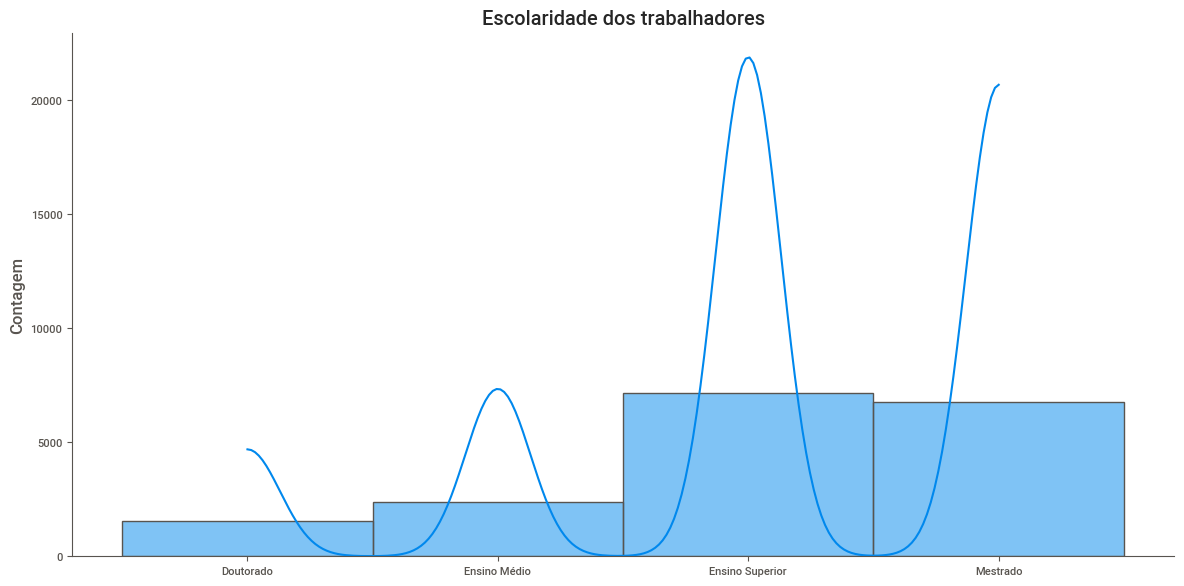

In [17]:
sns.displot(data=df, x="escolaridade", kde=True, height=6, aspect=2).set(title='Escolaridade dos trabalhadores', xlabel=None, ylabel='Contagem');

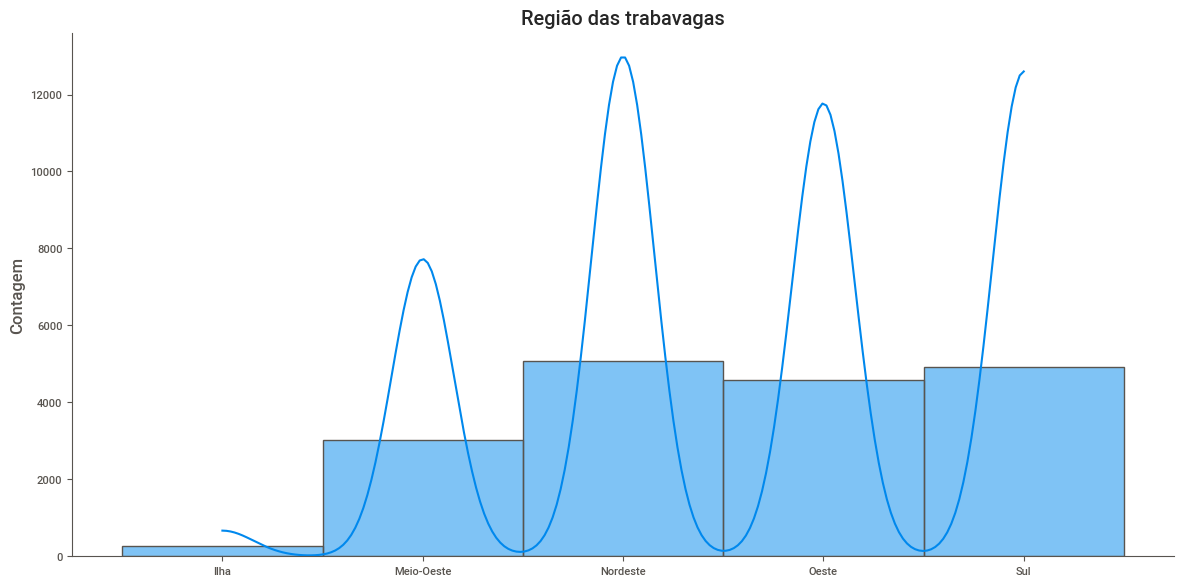

In [18]:
sns.displot(data=df, x="regiao", kde=True, height=6, aspect=2).set(title='Região das trabavagas', xlabel=None, ylabel='Contagem');

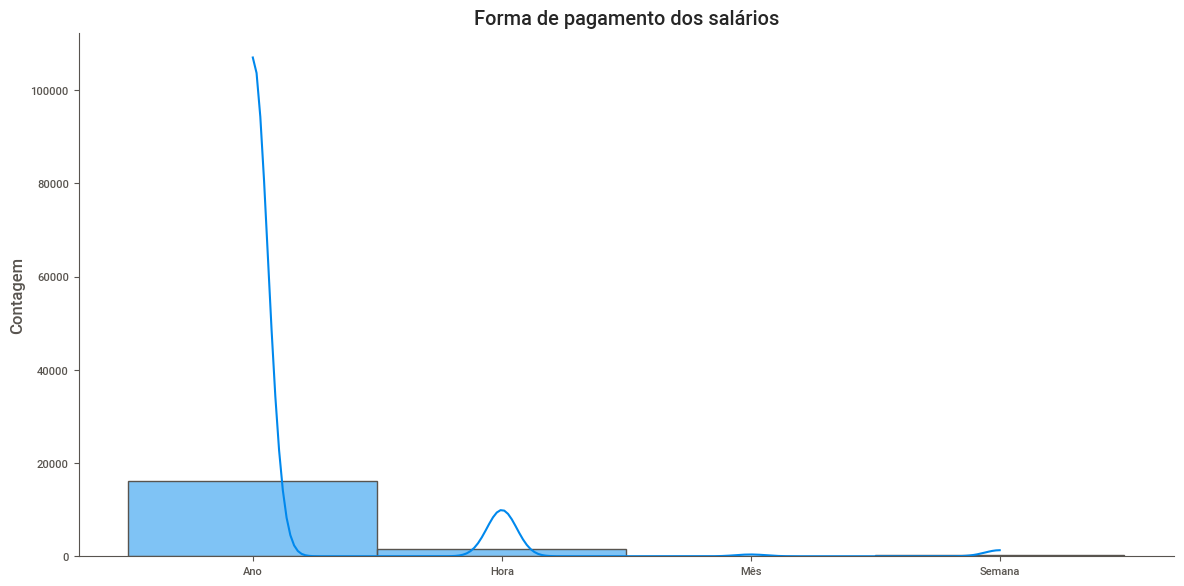

In [19]:
sns.displot(data=df, x="periodicidade", kde=True, height=6, aspect=2).set(title='Forma de pagamento dos salários', xlabel=None, ylabel='Contagem');

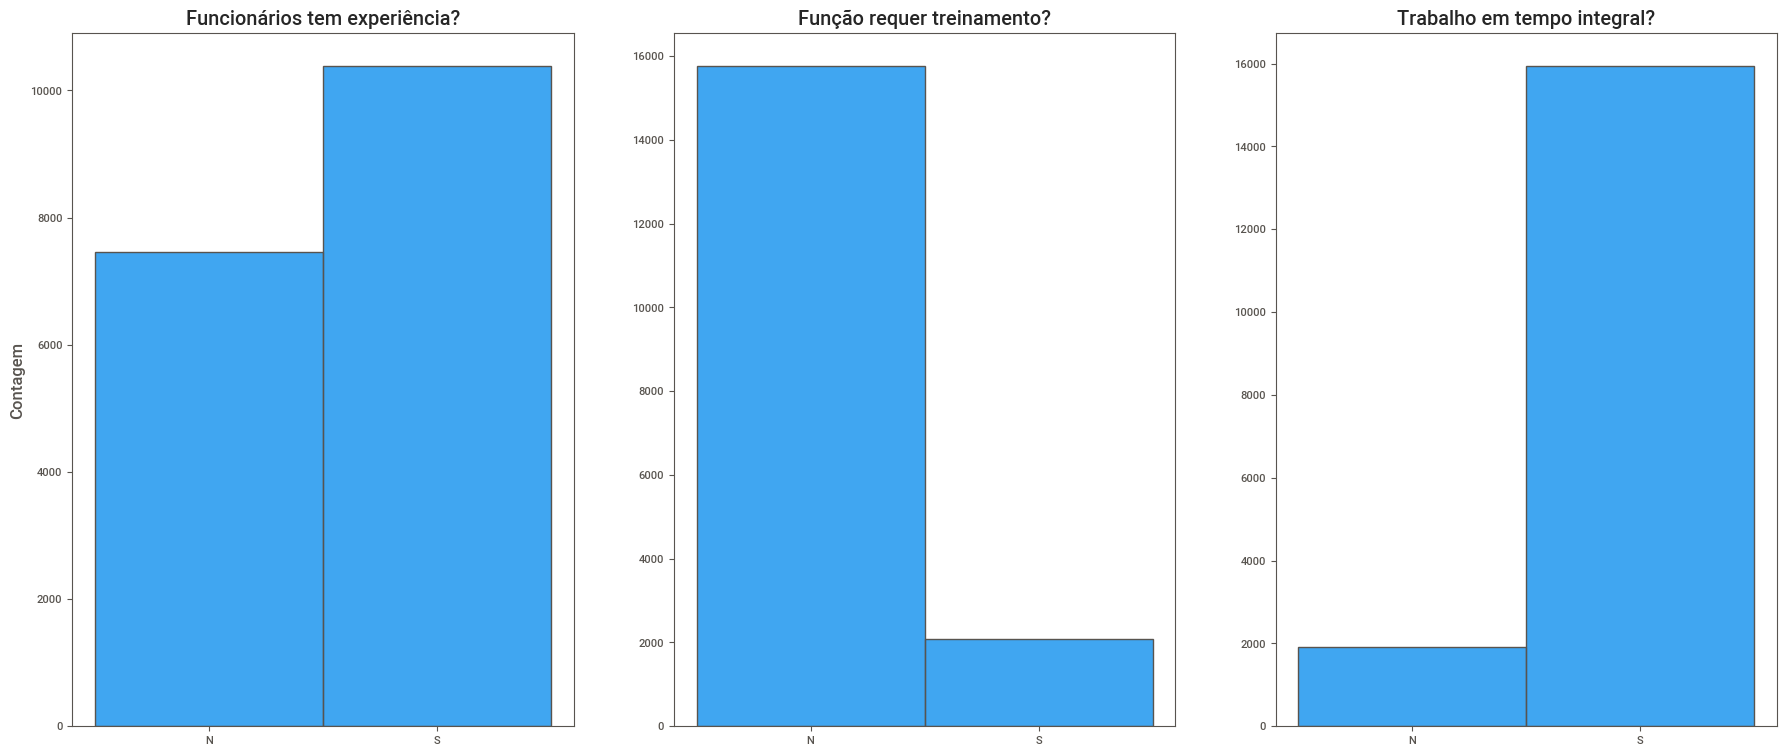

In [20]:
plt.subplot(1,3,1)
sns.histplot(data=df, x="tem_experiencia" ).set(title='Funcionários tem experiência?', xlabel=None, ylabel='Contagem');

plt.subplot(1,3,2)
sns.histplot(data=df, x="requer_treinamento", ).set(title='Função requer treinamento?', xlabel=None, ylabel=None);

plt.subplot(1,3,3)
sns.histplot(data=df, x="tempo_integral", ).set(title='Trabalho em tempo integral?', xlabel=None, ylabel=None);

Verificando a variância das features


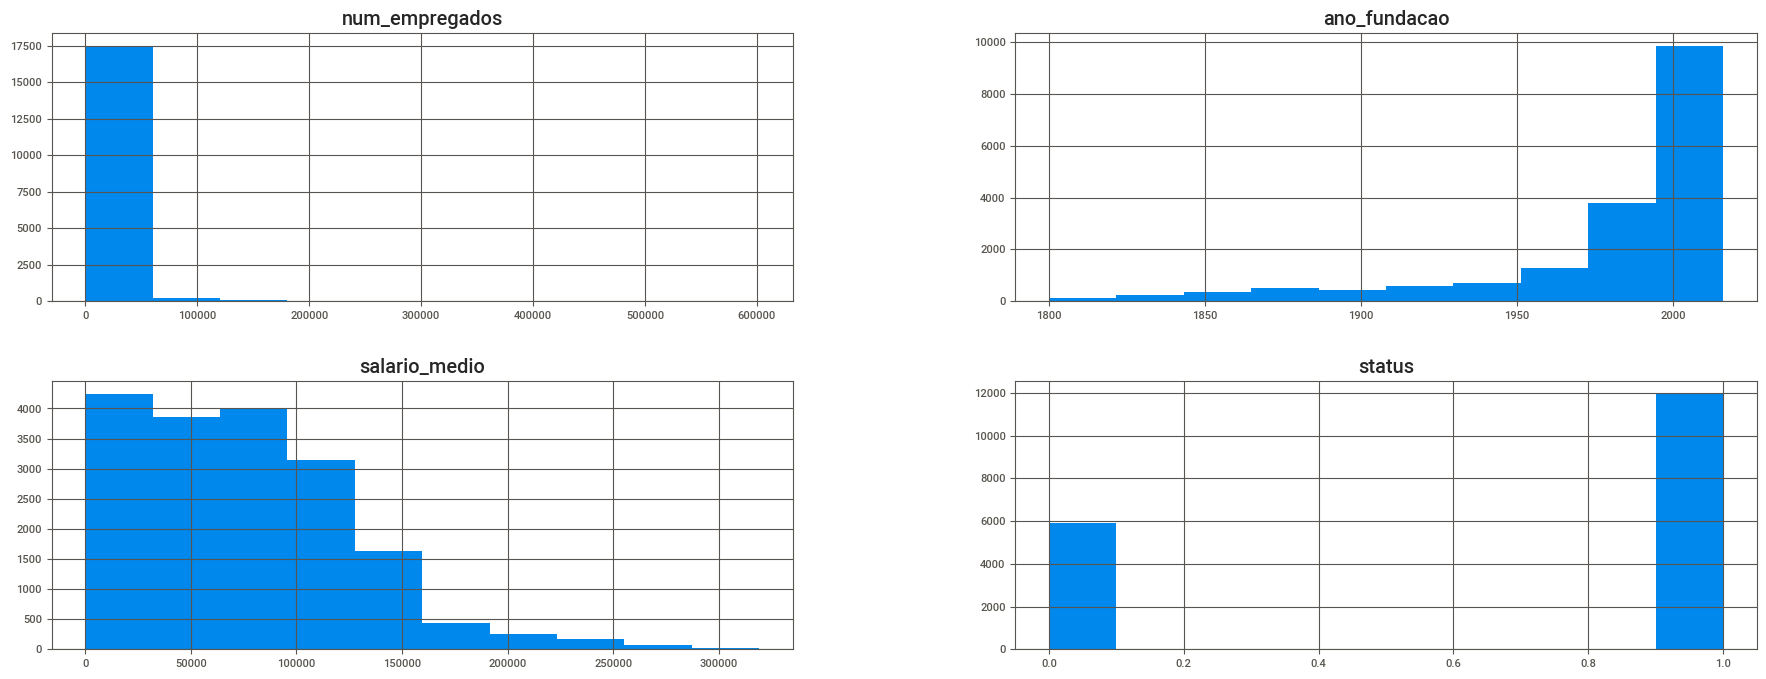

In [21]:
df.hist(figsize=(22,8));
print('Verificando a variância das features')

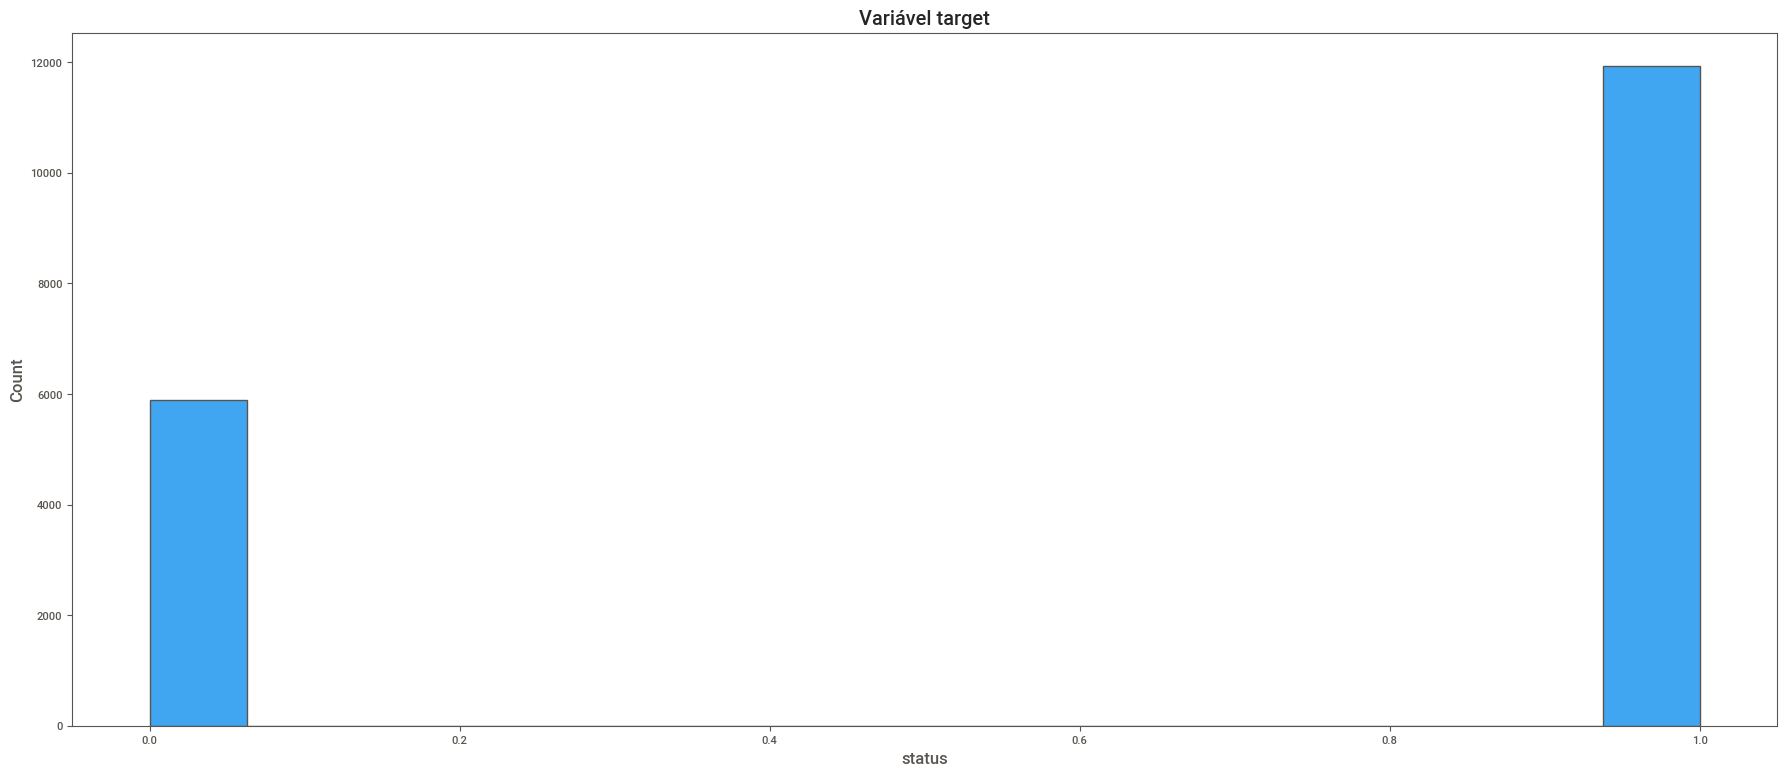

In [22]:
sns.histplot(df.status).set(title="Variável target");

## 2.2. Análise Bivariada

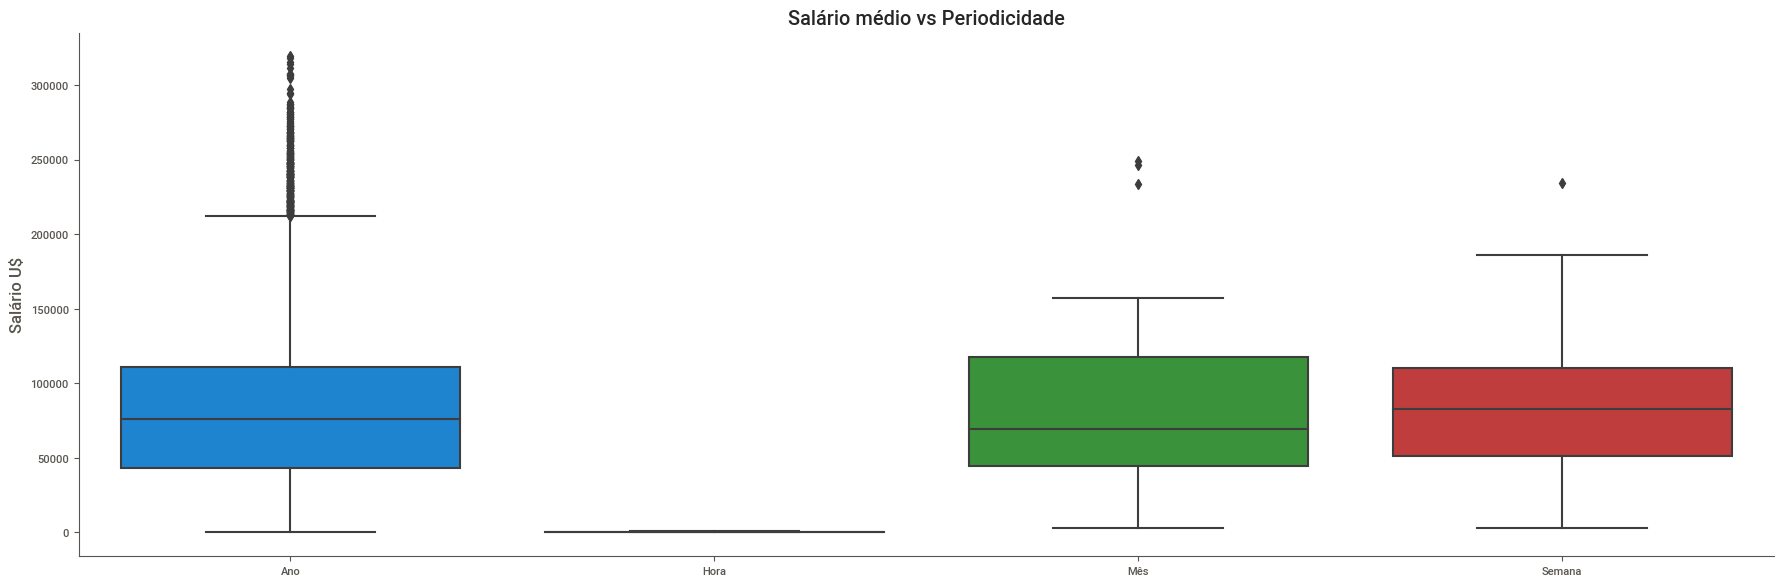

In [23]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', kind='box', height=6, aspect=3,).set(title='Salário médio vs Periodicidade', ylabel='Salário U$', xlabel=None);

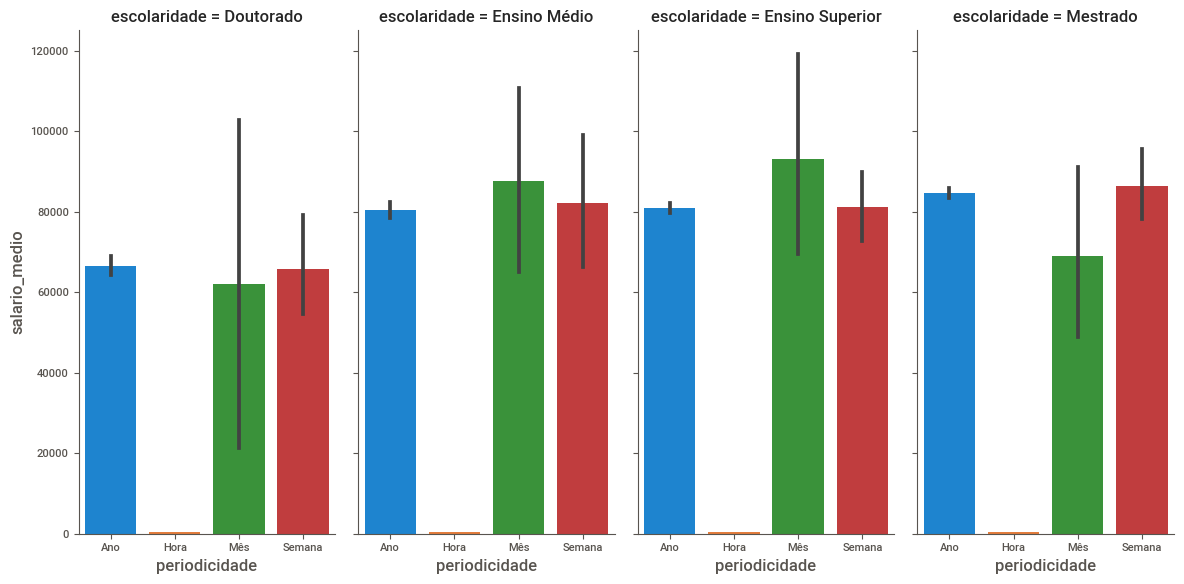

In [24]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', col='escolaridade', kind='bar', height=6, aspect=.5);

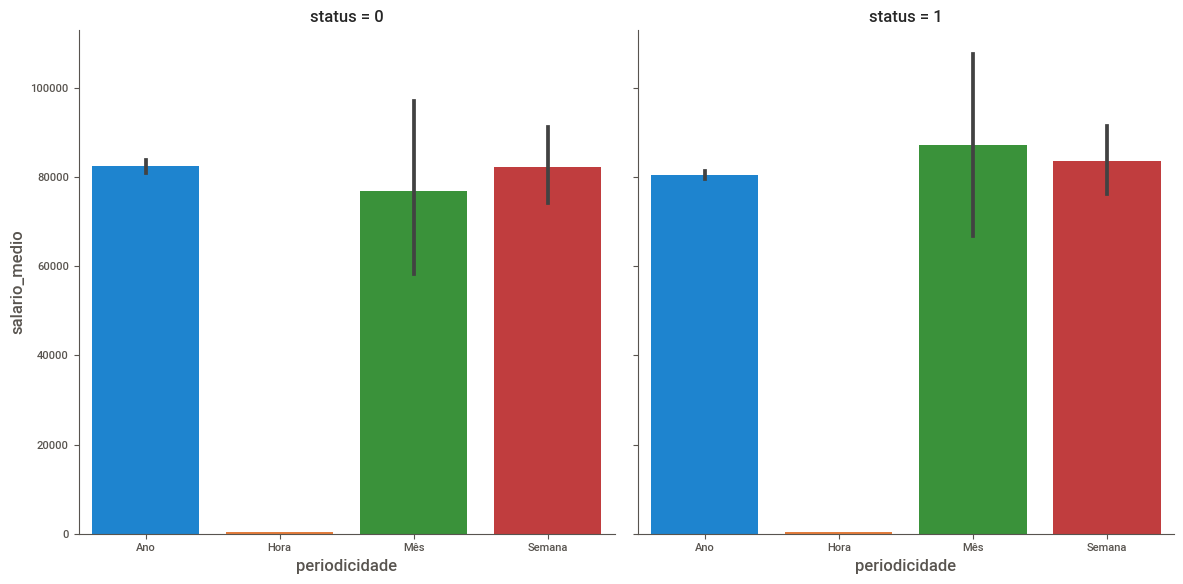

In [25]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', col='status', kind='bar', height=6, aspect=1);

[Text(0.5, 1.0, 'Escolaridade x Aprovação do visto'),
 Text(0, 0.5, 'Contagem'),
 Text(0.5, 0, '')]

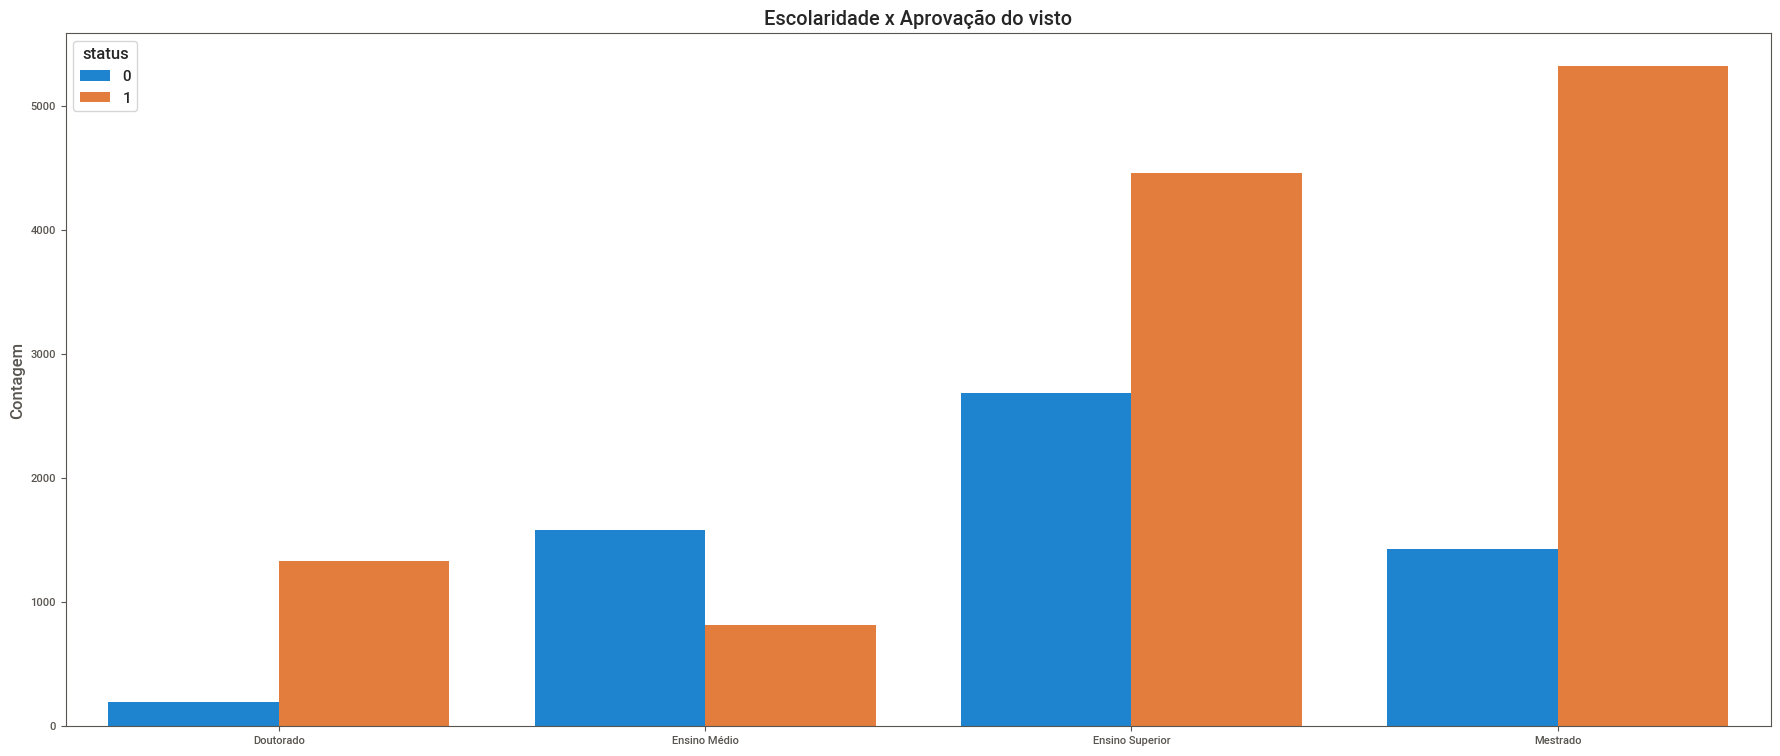

In [26]:
sns.countplot(data=df, x="escolaridade", hue="status").set(title='Escolaridade x Aprovação do visto', ylabel='Contagem', xlabel=None)

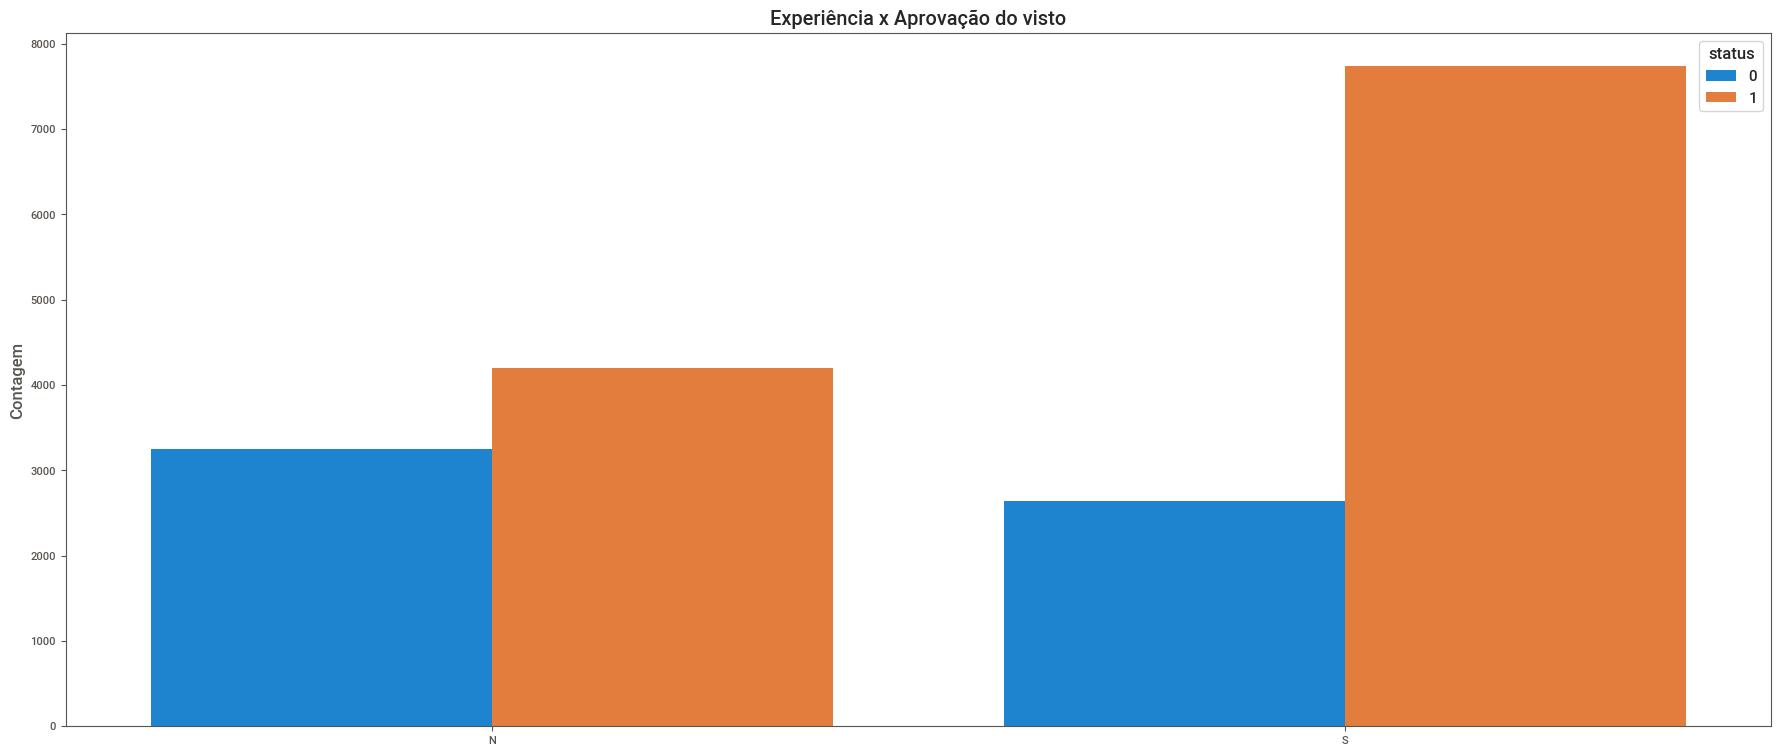

In [27]:
sns.countplot(data=df, x="tem_experiencia", hue="status").set(title='Experiência x Aprovação do visto', ylabel='Contagem', xlabel=None);

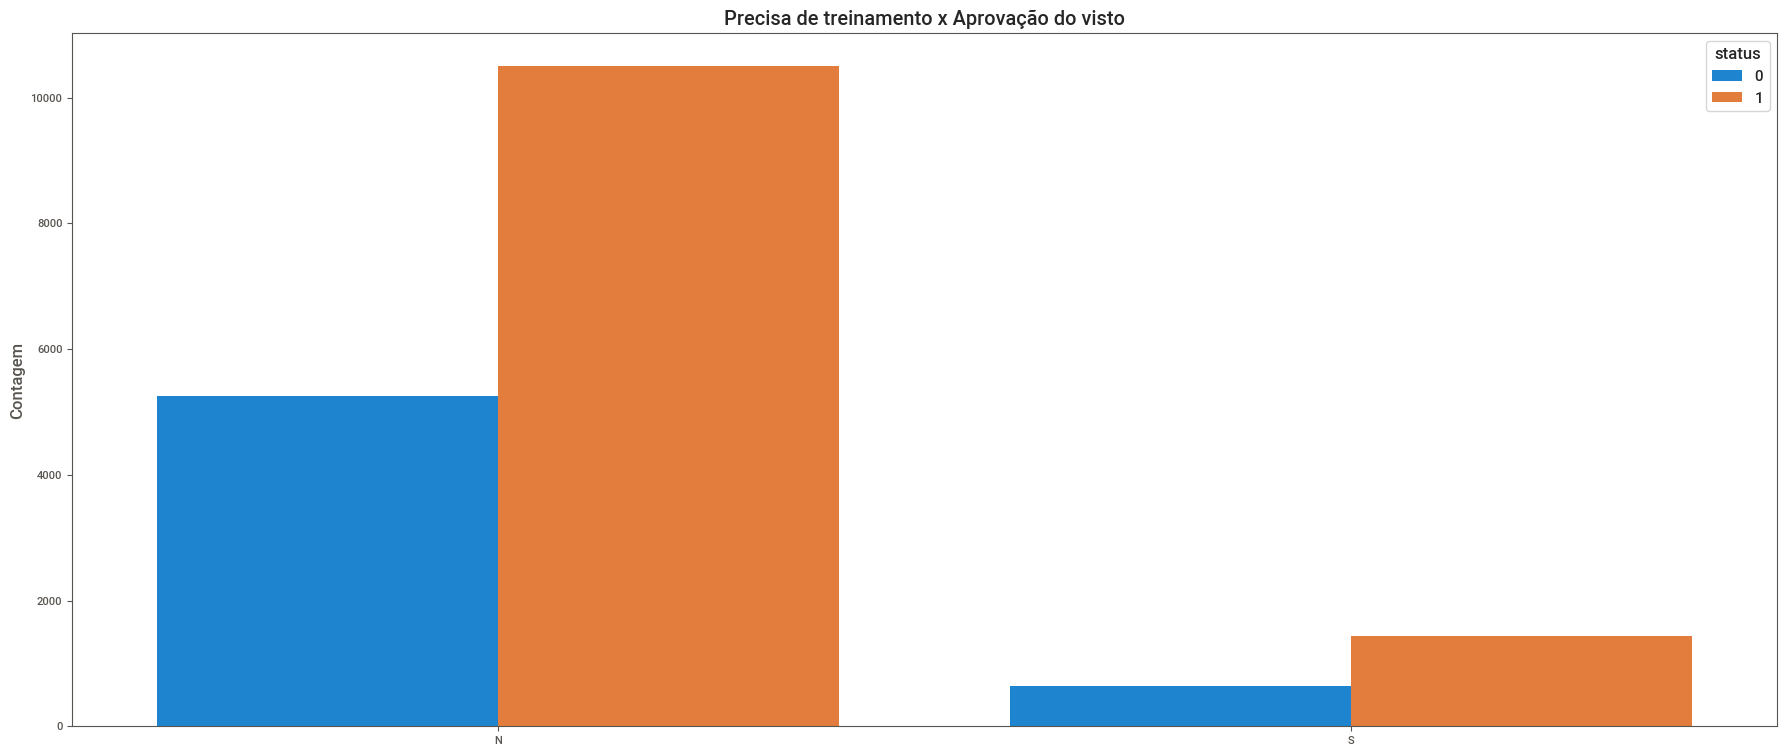

In [28]:
sns.countplot(data=df, x="requer_treinamento", hue="status").set(title='Precisa de treinamento x Aprovação do visto', ylabel='Contagem', xlabel=None);

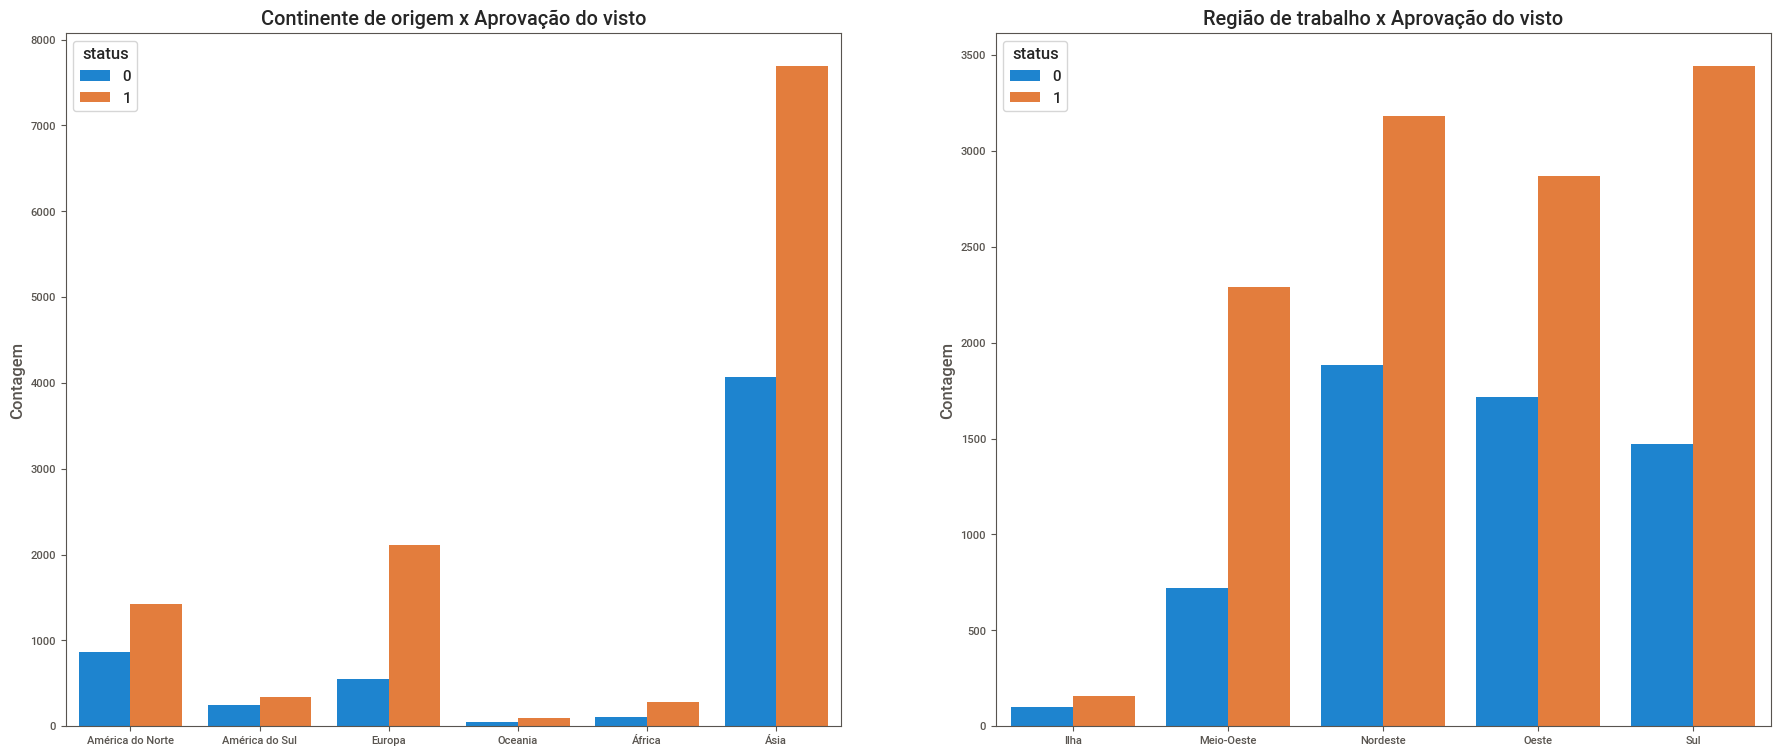

In [29]:
plt.subplot(1,2,1)
sns.countplot(data=df, x="continente", hue="status").set(title='Continente de origem x Aprovação do visto', ylabel='Contagem', xlabel=None);

plt.subplot(1,2,2)
sns.countplot(data=df, x="regiao", hue="status").set(title='Região de trabalho x Aprovação do visto', ylabel='Contagem', xlabel=None);


## 2.3. Análise Multivariada

In [30]:
corr = numerical_attributes.corr().round(1)
corr

,num_empregados,ano_fundacao,salario_medio,status
num_empregados,1.00,-0.00,-0.00,0.00
ano_fundacao,-0.00,1.00,0.00,0.00
salario_medio,-0.00,0.00,1.00,0.10
status,0.00,0.00,0.10,1.00


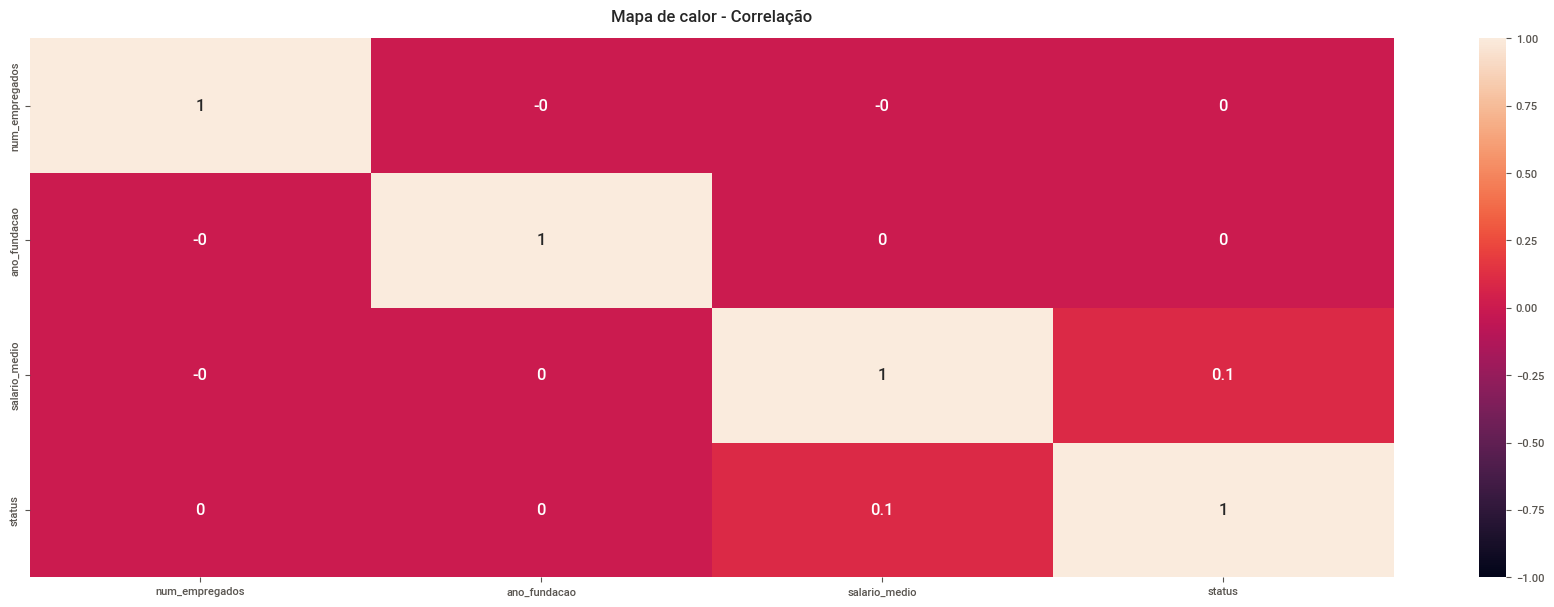

In [31]:
plt.figure(figsize=(22, 7))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Feature selection

## 3.1. Filtragem de linhas

In [32]:
# TODO

## 3.2. Filtragem de colunas

In [33]:
# TODO

# 4 - Data preparation

In [34]:
df2 = df.copy()

# dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["id", "status"], axis=1), df2["status"], test_size=0.2, random_state=42
)

# ======================== PRÉ PROCESSAMENTO ===============================
# pipeline para pré-processamento das variáveis binárias
for col in df2[['tem_experiencia', 'requer_treinamento', 'tempo_integral']].columns:
    df2[col] = df2[col].apply(lambda x: 0 if x=='N' else 1)



# pipeline para pré-processamento das variáveis categóricas
ordinal_transformer = Pipeline(steps=[("label encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Compondo os pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ( "ord", ordinal_transformer, list(df2[['continente', 'escolaridade', 'ano_fundacao', 'regiao', 'periodicidade']]) ),
    ]
)


# 5 - Modeling

## 5.1. Logistic Regression

c:\Users\Usuário\repos\google_ml\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Usuário\repos\google_ml\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


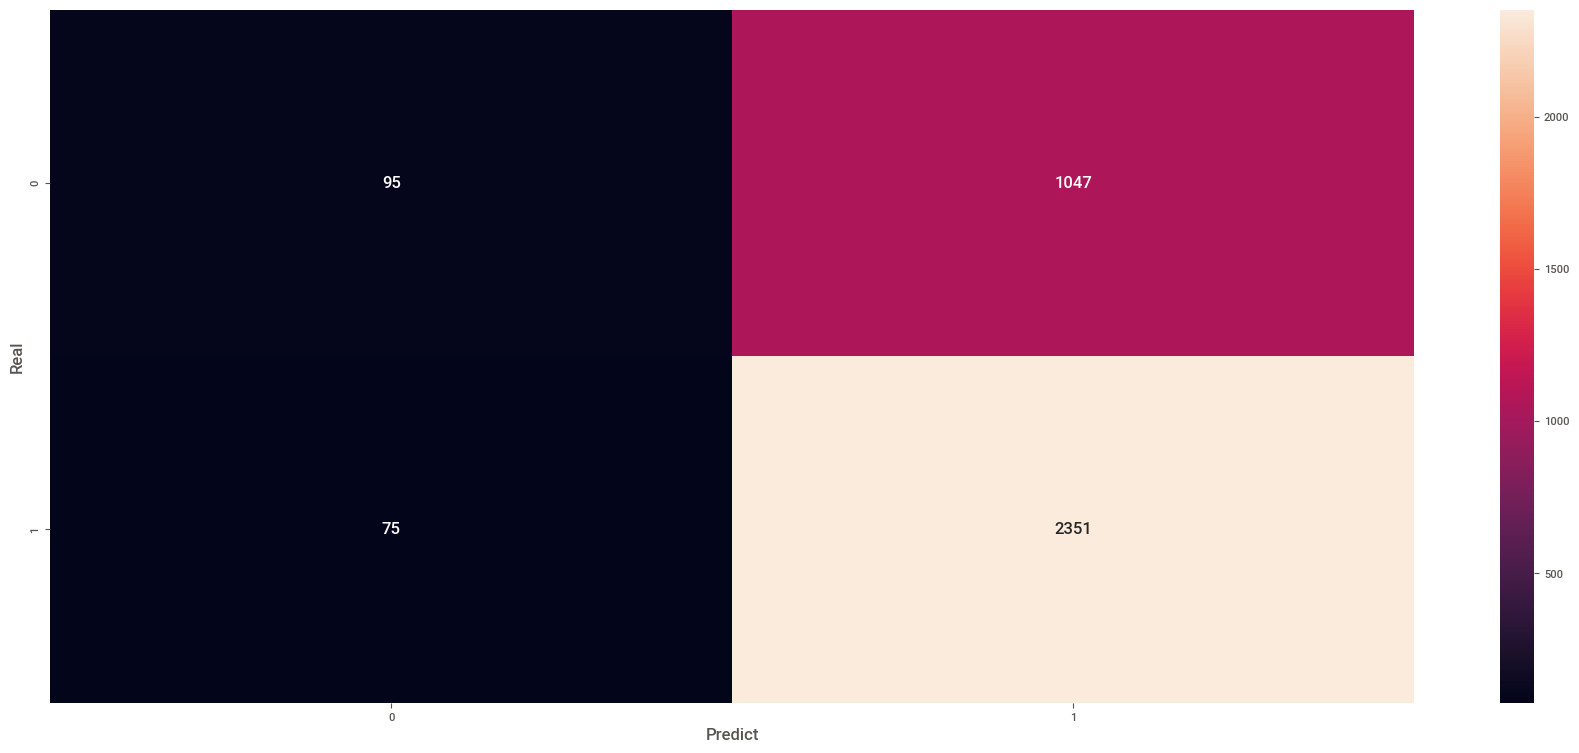

In [35]:
model_name = 'lr'
modelo = LogisticRegression()
parametros = { 
    "max_iter": [1, 5, 10],
    "penalty": ["l2", "l1"],
    "class_weight": ["balanced", None],
    'solver':['liblinear']
}

# O cross validation para descobrir os melhores parametros é realizado no dataset completo
best_params = tuning_hyperparams(preprocessor, modelo, model_name, parametros, df2.drop(["id", "status"], axis=1), df2["status"])

# Usando os melhores parâmetros do Cross validation
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "lr",
            LogisticRegression(
                class_weight    = best_params[model_name + '__' + "class_weight"],
                max_iter        = best_params[model_name + '__' + "max_iter"],
                penalty         = best_params[model_name + '__' + "penalty"],
                solver          = best_params[model_name + '__' + "solver"],
            ),
        ),
    ]
)

# treinando o modelo
model.fit(X_train, y_train)

# testando o modelo
y_pred = model.predict(X_test)

# Confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predict'])
sns.heatmap(confusion, annot=True, fmt='g');

In [36]:
lr_metrics_table = simple_metrics('Logistic Regression', y_test, y_pred)
lr_metrics_table

,Model,Precision,Recall,F1,AUC
0,Logistic Regression,0.69,0.97,0.81,0.53


# 6 -Submission

In [39]:
df_test = test_raw.copy()

## Pré processamento

In [40]:
df_test.columns = ['id', 'continente', 'escolaridade',
       'tem_experiencia', 'requer_treinamento',
       'num_empregados', 'ano_fundacao', 'regiao',
       'salario_medio', 'periodicidade',
       'tempo_integral', ]

df_test.id = df_test.id.astype('string')
df_test.continente = df_test.continente.astype('category')
df_test.escolaridade = df_test.escolaridade.astype('category')
df_test.tem_experiencia = df_test.tem_experiencia.astype('category')
df_test.requer_treinamento = df_test.requer_treinamento.astype('category')
df_test.num_empregados = df_test.num_empregados.astype('int32')
df_test.ano_fundacao = df_test.ano_fundacao.astype('int32')
df_test.regiao = df_test.regiao.astype('category')
df_test.salario_medio = df_test.salario_medio.astype('float32')
df_test.periodicidade = df_test.periodicidade.astype('category')
df_test.tempo_integral = df_test.tempo_integral.astype('category')



## Modelo

In [ ]:
# Usando os melhores parâmetros do Cross validation
model_submission = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "lr",
            LogisticRegression(
                class_weight    = best_params[model_name + '__' + "class_weight"],
                max_iter        = best_params[model_name + '__' + "max_iter"],
                penalty         = best_params[model_name + '__' + "penalty"],
                solver          = best_params[model_name + '__' + "solver"],
            ),
        ),
    ]
)

# treinando o modelo
model.fit(X_train, y_train)

# testando o modelo
df_test['status_do_caso'] = model.predict(df_test.drop(columns=['id']))

submission = df_test[['id', 'status_do_caso']].copy()
submission.columns = ['id_do_caso', 'status_do_caso']
submission.head()

In [43]:
submission.to_csv('../submissions/submission2.csv', index=False)